<a href="https://colab.research.google.com/github/tcharos/NLP-Toxicity-Detection/blob/main/AIDL_CS01_NLP_Project_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIDL_B_CS01: Advanced NLP Project

## 1. LSTM Toxicity Detection (Custom & GloVe Embeddings)



In [1]:
import os
import sys

IN_COLAB = 'google.colab' in sys.modules
BASE_DIR = "/content" if IN_COLAB else "."
TOXICITY_PATH = os.path.join(BASE_DIR, "data_sets/toxicity")

if IN_COLAB:
    print("Running in Google Colab. Installing NLP stack...")
    !pip install -q -U transformers datasets accelerate peft trl sentence-transformers
else:
    print("Running locally. Checking Mac-specific requirements...")
    !{sys.executable} -m pip install -q "tensorflow==2.16.2" "tensorflow-macos==2.16.2" "tf-keras~=2.16"
    !{sys.executable} -m pip install -q -U transformers datasets accelerate peft trl sentence-transformers

os.environ["KERAS_BACKEND"] = "tensorflow"

import torch
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import f1_score, confusion_matrix

from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments
)

from peft import LoraConfig, get_peft_model
from trl import DPOTrainer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


print(f"\nTensorFlow Version: {tf.__version__}")
print("Num GPUs Available (TF): ", len(tf.config.list_physical_devices('GPU')))

HAS_MPS = torch.backends.mps.is_available()
HAS_CUDA = torch.cuda.is_available()

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("PyTorch Device: Mac GPU (Metal)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch Device: Colab GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("PyTorch Device: CPU")

Running in Google Colab. Installing NLP stack...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 48.2 MB/s eta 0:00:00

TensorFlow Version: 2.19.0
Num GPUs Available (TF):  1
PyTorch Device: Colab GPU (CUDA)


In [2]:
os.makedirs(TOXICITY_PATH, exist_ok=True)

def download_toxicity_data():
    urls = {
        "train.csv": "https://raw.githubusercontent.com/Sreyan88/Toxicity-Detection-in-Spoken-Utterances/main/data/train.csv",
        "valid.csv": "https://raw.githubusercontent.com/Sreyan88/Toxicity-Detection-in-Spoken-Utterances/main/data/valid.csv",
        "test.csv": "https://raw.githubusercontent.com/Sreyan88/Toxicity-Detection-in-Spoken-Utterances/main/data/test.csv"
    }

    os.makedirs(TOXICITY_PATH, exist_ok=True)

    for name, url in urls.items():
        local_file = os.path.join(TOXICITY_PATH, name)
        if not os.path.exists(local_file):
            print(f"Fetching {name} from GitHub...")

            tf.keras.utils.get_file(
                fname=name,
                origin=url,
                cache_dir=BASE_DIR,
                cache_subdir="data_sets/toxicity"
            )

Fetching train.csv from GitHub...
1154330/1154330 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Fetching valid.csv from GitHub...
251778/251778 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Fetching test.csv from GitHub...
249870/249870 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Toxicity Data Set downloaded.


### Functions

In [11]:
download_toxicity_data()

print("\nToxicity Data Set downloaded.")


Toxicity Data Set downloaded.


In [3]:
def load_with_encoding(filename):
    try:
        return pd.read_csv(filename, encoding='utf-8')
    except UnicodeDecodeError:
        print(f"UTF-8 failed for {filename}, falling back to latin1")
        return pd.read_csv(filename, encoding='latin1')

def evaluate_binary(y_true, y_pred_probs, model_name="LSTM Model"):

    y_pred = (np.array(y_pred_probs) > 0.5).astype(int)

    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n--- Binary Classification: {model_name} ---")
    print(f"F1-Score: {f1:.4f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Clean', 'Toxic'], yticklabels=['Clean', 'Toxic'])
    plt.title(f'Toxicity Confusion Matrix\n{model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return f1, cm

def print_model_params(model, model_name, batch_size, epochs):
    print(f"\n{'='*20} {model_name} Hyperparameters {'='*20}")
    print(f"Epochs:          {epochs}")
    print(f"Batch Size:      {batch_size}")
    print(f"Optimizer:       {model.optimizer.__class__.__name__}")
    # Learning rate can be nested depending on the TF version
    lr = getattr(model.optimizer, 'learning_rate', 'N/A')
    if hasattr(lr, 'numpy'): lr = lr.numpy()
    print(f"Learning Rate:   {lr}")
    print(f"Loss Function:   {model.loss}")

    # Extract Embedding details
    emb_layer = model.layers[0]
    print(f"Embedding Dim:   {emb_layer.output_dim}")
    print(f"Vocab Size:      {emb_layer.input_dim}")
    print(f"Trainable Embs:  {emb_layer.trainable}")

    # Extract LSTM details
    lstm_layer = [l for l in model.layers if 'lstm' in l.name.lower()][0]
    print(f"LSTM Units:      {lstm_layer.units}")
    print(f"LSTM Dropout:    {lstm_layer.dropout}")
    print(f"{'='*60}\n")

## 1. Toxicity Detection with LSTM (Custom & GloVe Embeddings)

### 1.1. Data Loading and Preparation

In [4]:
DATA_PATH = os.path.join(BASE_DIR, "data_sets/toxicity/")

train_df = load_with_encoding(os.path.join(DATA_PATH, "train.csv"))
valid_df = load_with_encoding(os.path.join(DATA_PATH, "valid.csv"))
test_df = load_with_encoding(os.path.join(DATA_PATH, "test.csv"))

X_train, y_train = train_df['text'].astype(str), train_df['label2a']
X_valid, y_valid = valid_df['text'].astype(str), valid_df['label2a']
X_test, y_test = test_df['text'].astype(str), test_df['label2a']

MAX_WORDS = 10000
MAX_LEN = 60
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN)
X_valid_pad = pad_sequences(tokenizer.texts_to_sequences(X_valid), maxlen=MAX_LEN)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN)

vocab_size = len(tokenizer.word_index) + 1

UTF-8 failed for /content/data_sets/toxicity/train.csv, falling back to latin1
UTF-8 failed for /content/data_sets/toxicity/valid.csv, falling back to latin1
UTF-8 failed for /content/data_sets/toxicity/test.csv, falling back to latin1


In [5]:
def build_lstm(embedding_layer):
    model = Sequential([
        embedding_layer,
        SpatialDropout1D(0.2),
        LSTM(64, dropout=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### LSTM with Custom Learned Embeddings

In [6]:
# --- CUSTOM EMBEDDINGS ---
print("Training LSTM with Custom Embeddings...")
custom_emb_layer = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)
model_custom = build_lstm(custom_emb_layer)

model_custom.fit(X_train_pad, y_train, validation_data=(X_valid_pad, y_valid), epochs=5, batch_size=32)

Training LSTM with Custom Embeddings...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


370/370 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8032 - loss: 0.4586 - val_accuracy: 0.9166 - val_loss: 0.2271
Epoch 2/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9323 - loss: 0.1760 - val_accuracy: 0.9147 - val_loss: 0.2125
Epoch 3/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9538 - loss: 0.1163 - val_accuracy: 0.9066 - val_loss: 0.2318
Epoch 4/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9681 - loss: 0.0814 - val_accuracy: 0.9020 - val_loss: 0.2562
Epoch 5/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9769 - loss: 0.0622 - val_accuracy: 0.9047 - val_loss: 0.2926


In [ ]:
print_model_params(model_custom, "LSTM Custom", batch_size=32, epochs=5)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Binary Classification: LSTM (Custom Embeddings) ---
F1-Score: 0.8115


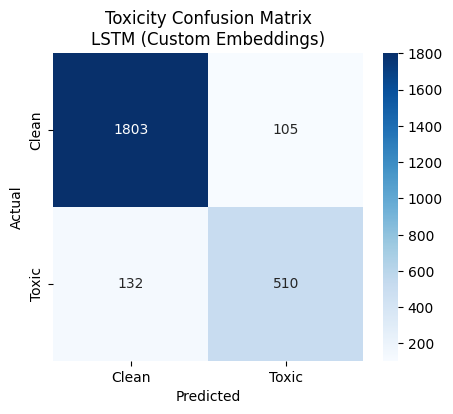

(0.8114558472553699,
 array([[1803,  105],
        [ 132,  510]]))

In [7]:
custom_probs = model_custom.predict(X_test_pad).flatten()

evaluate_binary(y_test, custom_probs, model_name="LSTM (Custom Embeddings)")

### LSTM with GloVe Learned Embeddings

In [8]:
def get_glove_matrix(path, word_index, emb_dim):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    matrix = np.zeros((len(word_index) + 1, emb_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            matrix[i] = embedding_vector
    return matrix

GLOVE_PATH = os.path.join(BASE_DIR, "data_sets", "glove.6B.100d.txt")

if not os.path.exists(GLOVE_PATH):
    if IN_COLAB:
        print("Downloading GloVe for Colab...")
        !wget http://nlp.stanford.edu/data/glove.6B.zip
        !unzip -j glove.6B.zip "glove.6B.100d.txt" -d {os.path.join(BASE_DIR, "data_sets")}
    else:
        print(f"Please ensure GloVe is at {GLOVE_PATH}")

try:
    embedding_matrix = get_glove_matrix(GLOVE_PATH, tokenizer.word_index, EMBEDDING_DIM)
    glove_emb_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix],
                                input_length=MAX_LEN, trainable=False)

    print("\nTraining LSTM with GloVe Embeddings...")
    model_glove = build_lstm(glove_emb_layer)
    model_glove.fit(X_train_pad, y_train, validation_data=(X_valid_pad, y_valid), epochs=5, batch_size=32)
except FileNotFoundError:
    print(f"\nSkipping GloVe: Could not find {GLOVE_PATH}")

--2026-01-14 08:03:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-01-14 08:03:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-01-14 08:03:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7628 - loss: 0.5004 - val_accuracy: 0.8720 - val_loss: 0.3274
Epoch 2/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8421 - loss: 0.3606 - val_accuracy: 0.8897 - val_loss: 0.2761
Epoch 3/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8793 - loss: 0.2899 - val_accuracy: 0.9020 - val_loss: 0.2460
Epoch 4/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8932 - loss: 0.2583 - val_accuracy: 0.9078 - val_loss: 0.2228
Epoch 5/5
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9076 - loss: 0.2242 - val_accuracy: 0.9116 - val_loss: 0.2184


In [ ]:
print_model_params(model_glove, "LSTM GloVe", batch_size=32, epochs=5)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Binary Classification: LSTM (GloVe Embeddings) ---
F1-Score: 0.8091


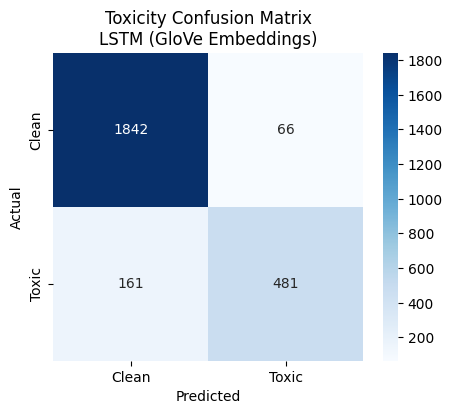

(0.8090832632464255,
 array([[1842,   66],
        [ 161,  481]]))

In [9]:
glove_probs = model_glove.predict(X_test_pad)

evaluate_binary(y_test, glove_probs, model_name="LSTM (GloVe Embeddings)")